# Passo 2: Adicionar jobs de processamento e treinamento do SageMaker
Neste passo, você move o processamento de dados e o treinamento do modelo para [contêineres Docker do SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html) e usa o [SDK Python do SageMaker](https://sagemaker.readthedocs.io/en/stable/index.html) para interagir com o SageMaker.

![](img/seis-etapas-2.png)

O SageMaker utiliza contêineres Docker para permitir que os desenvolvedores processem dados, treinem e implantem modelos. Os contêineres permitem que desenvolvedores e cientistas de dados empacotem software em unidades padronizadas que rodam consistentemente em qualquer plataforma que suporte Docker. Os contêineres garantem que o código, o ambiente de execução, as ferramentas do sistema, as bibliotecas do sistema e as configurações estejam todos no mesmo lugar, isolando-os do ambiente de execução. Isso garante uma experiência de execução consistente, independentemente de onde um contêiner esteja sendo executado.

O SageMaker também fornece contêineres pré-construídos com frameworks populares de processamento de dados e algoritmos de ML. Todos os algoritmos integrados do SageMaker são entregues como contêineres Docker.

<div class="alert alert-info"> Certifique-se de que você está usando o kernel <code>Python 3</code> no JupyterLab para este notebook.</div>

In [2]:
import time
import boto3
import botocore
import numpy as np  
import pandas as pd  
import sagemaker
import os
import mlflow
from time import gmtime, strftime, sleep
from sagemaker.processing import FrameworkProcessor, ProcessingInput, ProcessingOutput
from sagemaker.sklearn.estimator import SKLearn
from sklearn.metrics import roc_auc_score
from mlflow import MlflowClient

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.232.2'

In [3]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERRO] VOCÊ PRECISA EXECUTAR o notebook 00-inicie-aqui")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")


Stored variables and their in-db values:
baseline_s3_url                        -> 's3://sagemaker-us-east-1-533267005474/from-idea-t
bucket_name                            -> 'sagemaker-us-east-1-533267005474'
bucket_prefix                          -> 'from-idea-to-prod/xgboost'
dataset_file_local_path                -> 'data/bank-additional/bank-additional-full.csv'
domain_id                              -> 'd-j2g52sky4w9s'
evaluation_s3_url                      -> 's3://sagemaker-us-east-1-533267005474/from-idea-t
experiment_name                        -> 'from-idea-to-prod-experiment-14-17-01-59'
initialized                            -> True
input_s3_url                           -> 's3://sagemaker-us-east-1-533267005474/from-idea-t
mlflow_arn                             -> 'arn:aws:sagemaker:us-east-1:533267005474:mlflow-t
mlflow_name                            -> 'mlflow-d-j2g52sky4w9s-14-22-19-50'
model_package_group_name               -> 'from-idea-to-prod-pipeline-model-14-22

In [4]:
session = sagemaker.Session()
sm = session.sagemaker_client

## Preparar um experimento MLflow
Reutilize o experimento existente que criamos no notebook anterior. Você vai rastrear novas execuções no mesmo experimento.
Você também pode criar um novo experimento para rastrear as execuções neste notebook – neste caso, basta descomentar a célula de código a seguir.

In [13]:
experiment_suffix = strftime('%d-%H-%M-%S', gmtime())
registered_model_name = f"from-idea-to-prod-job-model-{experiment_suffix}"

In [14]:

# Descomente o bloco de código (Cmd + /) se você quiser criar um novo experimento

experiment_name = f"from-idea-to-prod-experiment-{experiment_suffix}"

In [15]:
mlflow.set_tracking_uri(mlflow_arn)
experiment = mlflow.set_experiment(experiment_name=experiment_name)

2024/10/14 22:55:43 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-experiment-14-22-55-42' does not exist. Creating a new experiment.


## Processar dados com jobs de processamento do SageMaker
Use o [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) simplesmente fornecendo um script Python de pré-processamento de dados e escolhendo uma classe [processador do SDK do SageMaker](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html).
Você deve fazer upload dos dados de entrada para o S3 e especificar uma localização no S3 para os dados de saída. O SageMaker Processing carrega automaticamente os dados de entrada do S3 e faz upload dos dados transformados de volta para o S3 quando o job é concluído. A imagem do contêiner de processamento pode ser uma imagem integrada do Amazon SageMaker ou uma imagem personalizada que você fornece. A infraestrutura subjacente para um job de Processamento é totalmente gerenciada pelo Amazon SageMaker. Os recursos do cluster são provisionados durante a duração do seu job e limpos quando um job é concluído.

Seus dados de entrada devem estar armazenados em um bucket do Amazon S3. Alternativamente, você pode usar [Amazon Athena](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) ou [Amazon Redshift](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) como fontes de entrada.

Faça o upload do conjunto de dados de entrada para um bucket do Amazon S3:

In [16]:
input_s3_url = session.upload_data(
    path="data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)

%store input_s3_url

Stored 'input_s3_url' (str)


In [17]:
# !aws s3 ls {bucket_name}/{bucket_prefix} --recursive

### Executar script de processamento em um contêiner Framework do SageMaker
Você começa executando seu script de processamento de dados em um contêiner gerenciado pré-construído do SageMaker.

<div class="alert alert-info"> Como você está usando MLflow no script de processamento, você precisa fornecer um arquivo <code>requirements.txt</code> para que o contêiner instale o MLflow e o plugin MLflow SageMaker antes de executar o script de processamento.</div>

In [18]:
dependencies_dir="./processing/requirements/"
%mkdir -p processing
%mkdir -p {dependencies_dir}

In [19]:
%%writefile {dependencies_dir}requirements.txt
mlflow==2.13.2
sagemaker-mlflow==0.1.0

Writing ./processing/requirements/requirements.txt


Crie um script Python movendo o código de processamento de dados do notebook do passo 1 para um arquivo .py e adicionando o rastreamento de experimentos com MLflow:

In [20]:
%%writefile processing/preprocessing.py

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
import numpy as np
import argparse
import os

from time import gmtime, strftime, sleep
import traceback

import mlflow

user_profile_name = os.getenv('USER')

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Diretórios de dados, modelo e saída
    # model_dir é sempre passado pelo SageMaker. Por padrão, este é um caminho S3 no bucket padrão.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()

def process_data(df_data):
    # Variável indicadora para capturar quando pdays assume um valor de 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicador para indivíduos não ativamente empregados
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remover dados desnecessários
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    bins = [18, 30, 40, 50, 60, 70, 90]
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

    df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
    df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
    df_model_data.drop('age', axis=1, inplace=True)
    df_model_data.drop('age_range', axis=1, inplace=True)

    scaled_features = ['pdays', 'previous', 'campaign']
    df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

    df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Converter variáveis categóricas em conjuntos de indicadores


    # Substitua “y_no” e “y_yes” por uma única coluna de rótulo e traga-a para a frente:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )
    
    return df_model_data

if __name__=="__main__":
    # Processa argumentos
    args, _ = _parse_args()
    
    target_col = "y"

    # Defina o URI do servidor de rastreamento usando o ARN do servidor de rastreamento que você criou
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_ARN'])
    
    # Habilitar o autologging no MLflow
    mlflow.autolog()

    # Use o run_id ativo para registrar 
    with mlflow.start_run(run_id=os.environ['MLFLOW_RUN_ID']) as run:
        # processa os dados
        df_model_data = process_data(pd.read_csv(os.path.join(args.filepath, args.filename), sep=";"))
    
        # Embaralhar e dividir o conjunto de dados
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )

        mlflow.set_tags(
            {
                'mlflow.user':user_profile_name,
                'mlflow.source.type':'JOB'
            }
        )
        
        # Salvar conjuntos de dados localmente
        train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
        validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
        test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
        test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
        
        # Salvar o conjunto de dados de baseline para monitoramento do modelo
        df_model_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)

        mlflow.log_artifact(local_path=os.path.join(args.outputpath, 'baseline/baseline.csv'))
    
    print("## Processing complete. Exiting.")

Writing processing/preprocessing.py


O script de processamento contém uma instrução para salvar o conjunto de dados completo sem o cabeçalho e a coluna de rótulo como um conjunto de dados de linha de base. Você precisará da linha de base de dados mais tarde no notebook de monitoramento do modelo.

Defina os caminhos do Amazon S3:

In [21]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"

In [22]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)


Defina a versão do framework e o tipo e número de instâncias de computação:

In [23]:
skprocessor_framework_version = "1.2-1"
processing_instance_type = "ml.m5.large"
processing_instance_count = 1

#### Criar uma execução de experimento
Crie uma nova execução em seu experimento para rastrear parâmetros, configuração, entradas e saídas do job de processamento.

In [24]:
run_suffix = strftime('%d-%H-%M-%S', gmtime())
run_name = f"processamento-do-container-{run_suffix}"

run_id = mlflow.start_run(
    run_name=run_name,
    description="engenharia de features no notebook 02 com um job de processamento").info.run_id


#### Criar um processador e definir entradas e saídas
Instancie um objeto [`FrameworkProcessor`](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) antes de iniciar o job de processamento do SageMaker. Você especifica o tipo de instância a ser usado no job, bem como quantas instâncias para processamento distribuído.

Observe como o SageMaker mapeia seus dados para os caminhos locais no volume EBS do contêiner de processamento:

![](img/data-processing.png)

In [25]:
sklearn_processor = FrameworkProcessor(
    estimator_cls=SKLearn,
    framework_version=skprocessor_framework_version,
    role=sm_role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name='from-idea-to-prod-processing',
    sagemaker_session=session,
    env={
        'MLFLOW_TRACKING_ARN': mlflow_arn,
        'MLFLOW_RUN_ID': run_id,
        'USER': user_profile_name
    }
)

processing_inputs = [
        ProcessingInput(
            source=input_s3_url, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        ),
        ProcessingInput(
            input_name="processor",
            source=dependencies_dir,
            destination="/opt/ml/processing/input/code/requirements/",
        ),
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url
        ),
        ProcessingOutput(
            output_name="baseline_data", 
            source="/opt/ml/processing/output/baseline", 
            destination=baseline_s3_url
        ),
    ]

#### Iniciar o job de processamento do SageMaker

<svg width="800" height="125" viewBox="0 0 800 125" xmlns="http://www.w3.org/2000/svg">
    <defs>
        <linearGradient id="fadeGradient" x1="0" x2="1">
            <stop offset="0%" stop-color="#F0F0F0"/>
            <stop offset="100%" stop-color="#F0F0F0" stop-opacity="0"/>
        </linearGradient>
        <mask id="fadeMask">
            <rect x="0" y="0" width="750" height="125" fill="white"/>
            <rect x="750" y="0" width="50" height="125" fill="url(#fadeGradient)"/>
        </mask>
    </defs>
    <path d="M3,50 A50,50 0 0 1 53,3 L797,3 L797,97 L97,97 L50,115 L3,97 Z" fill="#F0F0F0" stroke="#E0E0E0" stroke-width="1" mask="url(#fadeMask)"/>
    <circle cx="50" cy="50" r="30" fill="#57c4f8" stroke="#57c4f8" stroke-width="1"/>
    <circle cx="50" cy="50" r="25" fill="#F0F0F0"/>
    <line x1="50" y1="50" x2="50" y2="30" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <line x1="50" y1="50" x2="65" y2="50" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <text x="100" y="34" font-family="Arial, sans-serif" font-size="14" fill="#333333">A próxima célula pode levar alguns minutos para executar.</text>
</svg>

In [26]:
sklearn_processor.run(
    inputs=processing_inputs,
    outputs=processing_outputs,
    code='processing/preprocessing.py',
    dependencies=[f'{dependencies_dir}requirements.txt'],
    wait=True,
    # arguments = ['arg1', 'arg2'],
)

mlflow.set_tags(
    {
        'mlflow.source.name':f'https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/processing-jobs/{sklearn_processor.latest_job.name}',
    }
)

mlflow.end_run()

INFO:sagemaker:Creating processing-job with name from-idea-to-prod-processing-2024-10-14-22-56-50-285


.............CodeArtifact repository not specified. Skipping login.
Found existing installation: typing 3.7.4.3
Uninstalling typing-3.7.4.3:
  Successfully uninstalled typing-3.7.4.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 160.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 175.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.5/746.5 kB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 176.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 140.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 156.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 121.9 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.85
    Uninstalling botocore-1.31.85:
      Successfully uninstalled botocore-1.31.85
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.7.0
    Uninstall

2024/10/14 23:02:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run processamento-do-container-14-22-56-45 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/7/runs/12d07352e5c54dea8ca547b69423ca38.
2024/10/14 23:02:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/7.


In [28]:
# Se você definiu wait como False na célula de código anterior, aguarde até que o job seja concluído
while sm.describe_processing_job(
        ProcessingJobName=sklearn_processor._current_job_name
    )["ProcessingJobStatus"] != "Completed":
    time.sleep(10)  # Aguarde 10 segundos
    print(f"Aguarde até que {sklearn_processor._current_job_name} seja concluído")
else:
    print(f"{sklearn_processor._current_job_name} foi concluído")


from-idea-to-prod-processing-2024-10-14-22-56-50-285 foi concluído


Para esperar a conclusão do job, você também pode usar os `boto3` [waiters](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#waiters). Por exemplo:

```python
waiter = session.sagemaker_client.get_waiter('processing_job_completed_or_stopped')
waiter.wait(ProcessingJobName=sklearn_processor._current_job_name)

In [29]:
# listar os arquivos carregados
# !aws s3 ls {bucket_name}/{bucket_prefix} --recursive

### Execute o script de processamento localmente e remotamente como um job do SageMaker
Você pode usar o [SageMaker Python SDK decorator `@remote`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html) para executar seu código local no notebook como um job de processamento do SageMaker – chamado de "Remote Function". Esta é uma maneira ainda mais fácil de executar seu código Python em escala usando o processamento e treinamento distribuído do SageMaker.

Consulte a [documentação](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator.html) no guia do desenvolvedor do Amazon SageMaker.

Na seção a seguir, você executará o código de processamento de dados como um job do SageMaker usando o decorador `@remote`.

#### Etapa 1: Desenvolva e teste seu código localmente
Primeiro, você implementa e testa seu código localmente no notebook para verificar a correção do código e do ambiente.

In [30]:
# Carregar o conjunto de dados em um DataFrame
file_name = "bank-additional-full.csv"
input_path = "./data/bank-additional" 
df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

In [31]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# definir uma função local
def preprocess(
    df_data,
    tracking_server_arn=mlflow_arn,
    experiment_name=None,
    run_id=None,
):
    import mlflow
    from time import gmtime, strftime

    try:
        # Definir a URI do Servidor de Rastreamento usando o ARN do Servidor de Rastreamento que você criou
        mlflow.set_tracking_uri(tracking_server_arn)
        
        # Habilitar autologging no MLflow
        mlflow.autolog()
    
        suffix = strftime('%d-%H-%M-%S', gmtime())
        mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"preprocess-{suffix}")
        run = mlflow.start_run(run_id=run_id) if run_id else mlflow.start_run(run_name=f"local-processing-{suffix}", nested=True)
    
        target_col = "y"
        
        # Variável indicadora para capturar quando pdays assume o valor de 999
        df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)
    
        # Indicador para indivíduos não ativamente empregados
        df_data["not_working"] = np.where(
            np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
        )
    
        # remover dados desnecessários
        df_model_data = df_data.drop(
            ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
            axis=1,
        )
    
        bins = [18, 30, 40, 50, 60, 70, 90]
        labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']
    
        df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
        df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
        df_model_data.drop('age', axis=1, inplace=True)
        df_model_data.drop('age_range', axis=1, inplace=True)
    
        scaled_features = ['pdays', 'previous', 'campaign']
        df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])
    
        df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Converter variáveis categóricas em conjuntos de indicadores
    
        # Substituir "y_no" e "y_yes" por uma única coluna de rótulo e trazê-la para a frente:
        df_model_data = pd.concat(
            [
                df_model_data["y_yes"].rename(target_col),
                df_model_data.drop(["y_no", "y_yes"], axis=1),
            ],
            axis=1,
        )
    
        # Embaralhar e dividir o conjunto de dados
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )
        
        baseline_data = df_model_data.drop([target_col], axis=1)
        
        print("## Processing complete. Exiting.")
        
        return train_data, validation_data, test_data, baseline_data

    except Exception as e:
        print(f"Exception in processing script: {e}")
        raise e
    finally:
        mlflow.end_run()

In [32]:
# Chamar a função localmente

train_data, validation_data, test_data, baseline_data = preprocess(df_data, experiment_name=experiment_name)

2024/10/14 23:03:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/14 23:03:19 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/10/14 23:03:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
2024/10/14 23:03:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run local-processing-14-23-03-19 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/7/runs/dfd7e1d1b1c94686b424fb49e78fdd93.
2024/10/14 23:03:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/7.


Data split > train:(28831, 65) | validation:(8238, 65) | test:(4119, 65)
## Processing complete. Exiting.


In [33]:
# ver os dados processados

train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


#### Etapa 2: Execute a função remotamente usando RemoteExecutor
Você pode usar a classe [`RemoteExecutor`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html#remoteexecutor) do SDK Python do SageMaker para executar a função local remotamente como um job do SageMaker. Você pode executar vários jobs em paralelo usando o parâmetro `max_parallel_jobs` para controlar o número máximo de jobs paralelos.

In [34]:
from sagemaker.remote_function import remote, RemoteExecutor

In [35]:
s3_root_uri = f"s3://{bucket_name}/{bucket_prefix}"

In [36]:
# este código iniciará um job do SageMaker para executar o script de pré-processamento
with RemoteExecutor(dependencies=f"{dependencies_dir}requirements.txt",
                    s3_root_uri=s3_root_uri, instance_type=processing_instance_type) as e:
    future = e.submit(preprocess, df_data)    

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-10-14 23:03:46,233 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/preprocess-2024-10-14-23-03-46-232/function
2024-10-14 23:03:46,311 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/preprocess-2024-10-14-23-03-46-232/arguments
2024-10-14 23:03:47,302 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmpm6dfg4xr/temp_workspace/sagemaker_remote_function_workspace'
2024-10-14 23:03:47,303 sagemaker.remote_function INFO     Copied dependencies file at './processing/requirements/requirements.txt' to '/tmp/tmpm6dfg4xr/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2024-10-14 23:03:49,491 sagemaker.remote_function INFO     Successfully created workdir archive at '/tmp/tmpm6dfg4xr/workspace.zip'
2024-10-14 23:03:50,033 sagemaker.remote_function INFO     Successfully uploaded workdir to 's

In [37]:
train_data, validation_data, test_data, baseline_data = future.result()

2024-10-14 23:07:16 Starting - Preparing the instances for training
2024-10-14 23:07:16 Downloading - Downloading the training image
2024-10-14 23:07:16 Training - Training image download completed. Training in progress.
2024-10-14 23:07:16 Uploading - Uploading generated training model
2024-10-14 23:07:16 Completed - Training job completedINFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
2024-10-14 23:06:45,085 sagemaker.remote_function INFO     The job is running on non-root user: sagemaker-user. Adding write permissions to the following job output directories: ['/opt/ml/output', '/opt/ml/model', '/tmp'].
2024-10-14 23:06:45,088 sagemaker.remote_function INFO     Executing 'sudo chmod -R 777 /opt/ml/output /opt/ml/model /tmp'.
2024-10-14 23:06:45,336 sagemaker.remote_f

In [39]:
# veja os dados processados
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


#### Etapa 3: Executar código com o decorador @remote
Agora você pode aplicar `@remote` à função uma vez que os testes locais e remotos sejam executados com sucesso. 
Você também pode definir configurações padrão para funções remotas por meio de um [configuration file](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-config.html). O arquivo de configuração é usado ao invocar uma função com o decorador `@remote` ou a API `RemoteExecutor`. Você usará arquivos de configuração do SageMaker no notebook 3 para configurar pipelines do SageMaker.

In [40]:
@remote(dependencies=f"{dependencies_dir}requirements.txt",
        s3_root_uri=s3_root_uri, instance_type=processing_instance_type)
def preprocess(
    df_data,
    tracking_server_arn=mlflow_arn,
    experiment_name=None,
    run_id=None,
):
    import mlflow
    from time import gmtime, strftime

    try:
        # Definir a URI do Servidor de Rastreamento usando o ARN do Servidor de Rastreamento que você criou
        mlflow.set_tracking_uri(tracking_server_arn)
        
        # Habilitar autologging no MLflow
        mlflow.autolog()
    
        suffix = strftime('%d-%H-%M-%S', gmtime())
        mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"preprocess-{suffix}")
        run = mlflow.start_run(run_id=run_id) if run_id else mlflow.start_run(run_name=f"remote-processing-{suffix}", nested=True)
    
        target_col = "y"
        
        # Variável indicadora para capturar quando pdays assume o valor de 999
        df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)
    
        # Indicador para indivíduos não ativamente empregados
        df_data["not_working"] = np.where(
            np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
        )
    
        # remover dados desnecessários
        df_model_data = df_data.drop(
            ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
            axis=1,
        )
    
        bins = [18, 30, 40, 50, 60, 70, 90]
        labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']
    
        df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
        df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
        df_model_data.drop('age', axis=1, inplace=True)
        df_model_data.drop('age_range', axis=1, inplace=True)
    
        scaled_features = ['pdays', 'previous', 'campaign']
        df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])
    
        df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Converter variáveis categóricas em conjuntos de indicadores
    
        # Substituir "y_no" e "y_yes" por uma única coluna de rótulo e trazê-la para a frente:
        df_model_data = pd.concat(
            [
                df_model_data["y_yes"].rename(target_col),
                df_model_data.drop(["y_no", "y_yes"], axis=1),
            ],
            axis=1,
        )
    
        # Embaralhar e dividir o conjunto de dados
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )
        
        baseline_data = df_model_data.drop([target_col], axis=1)
        
        print("## Processing complete. Exiting.")
        
        return train_data, validation_data, test_data, baseline_data

    except Exception as e:
        print(f"Exception in processing script: {e}")
        raise e
    finally:
        mlflow.end_run()
    return train_data, validation_data, test_data, baseline_data

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


In [42]:
# Esta chamada cria e executa um job do SageMaker
# Isso também criará um novo experimento no MLflow
train_data, validation_data, test_data, baseline_data = preprocess(df_data, experiment_name=experiment_name)

2024-10-14 23:12:12,478 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/preprocess-2024-10-14-23-12-12-478/function
2024-10-14 23:12:12,605 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/preprocess-2024-10-14-23-12-12-478/arguments
2024-10-14 23:12:13,070 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmp8tdha_u7/temp_workspace/sagemaker_remote_function_workspace'
2024-10-14 23:12:13,073 sagemaker.remote_function INFO     Copied dependencies file at './processing/requirements/requirements.txt' to '/tmp/tmp8tdha_u7/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2024-10-14 23:12:15,545 sagemaker.remote_function INFO     Successfully created workdir archive at '/tmp/tmp8tdha_u7/workspace.zip'
2024-10-14 23:12:16,138 sagemaker.remote_function INFO     Successfully uploaded workdir to 's

2024-10-14 23:12:17 Starting - Starting the training job...
2024-10-14 23:12:32 Starting - Preparing the instances for training...
2024-10-14 23:12:59 Downloading - Downloading input data...
2024-10-14 23:13:29 Downloading - Downloading the training image.........
2024-10-14 23:15:05 Training - Training image download completed. Training in progress.INFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
2024-10-14 23:15:09,459 sagemaker.remote_function INFO     The job is running on non-root user: sagemaker-user. Adding write permissions to the following job output directories: ['/opt/ml/output', '/opt/ml/model', '/tmp'].
2024-10-14 23:15:09,460 sagemaker.remote_function INFO     Executing 'sudo chmod -R 777 /opt/ml/output /opt/ml/model /tmp'.
2024-10-14 23:15:09,694 sagemake

In [44]:
# veja os dados processados
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


Para mais exemplos de funções remotas, veja os [notebooks de exemplo](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-examples.html) do SageMaker.

## Treinamento de modelo com jobs de treinamento do SageMaker
Siga a mesma abordagem e agora execute o treinamento do modelo como um [job de treinamento do SageMaker](https://sagemaker.readthedocs.io/en/stable/overview.html#using-estimators) com um contêiner de framework integrado no modo de script. O modo de script significa que você fornece um script para ser executado em um dos contêineres gerenciados pré-definidos do SageMaker. Com essa abordagem, você pode se concentrar no desenvolvimento do código enquanto usa ambientes de execução padrão fornecidos pelo SageMaker. Você também pode primeiro executar seu código localmente em um contêiner Docker no espaço Studio JupyterLab e depois passar para jobs remotos do SageMaker.

In [45]:
!mkdir -p ./training/
!sudo rm -rf ./training-local/
!mkdir -p ./training-local/

### Desenvolva um script de treinamento
Prepare um script de treinamento usando o framework XGBoost.

In [66]:
%%writefile ./training/train.py

import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

from sklearn.metrics import roc_auc_score

import xgboost as xgb
import mlflow

from time import gmtime, strftime

suffix = strftime('%d-%H-%M-%S', gmtime())

user_profile_name = os.getenv('USER', 'sagemaker')
experiment_name = os.getenv('MLFLOW_EXPERIMENT_NAME')
region = os.getenv('REGION')

mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_ARN'))
mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"train-{suffix}")

def _xgb_train(params, dtrain, dval, evals, num_boost_round, model_dir, is_master):
    """Executa o treinamento xgb nos argumentos fornecidos com o rabit inicializado.

    Esta é nossa função de execução rabit.

    :param args_dict: Dicionário de argumentos usado para executar xgb.train().
    :param is_master: Verdadeiro se o nó atual for o host mestre no treinamento distribuído,
                        ou estiver executando um job de treinamento de nó único.
                        Observe que rabit_run inclui este argumento.
    """
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=evals,
        num_boost_round=num_boost_round
    )

    val_auc = roc_auc_score(dval.get_label(), booster.predict(dval))
    train_auc = roc_auc_score(dtrain.get_label(), booster.predict(dtrain))
    mlflow.log_params(params)
    mlflow.log_metrics({"validation_auc":val_auc, "train_auc":train_auc})
    # emitir métricas de treinamento - SageMaker as coleta do fluxo de log
    print(f"[0]#011train-auc:{train_auc}#011validation-auc:{val_auc}")
    
    if is_master:
        model_location = model_dir + '/xgboost-model'
        pkl.dump(booster, open(model_location, 'wb'))
        print("Modelo treinado armazenado em {}".format(model_location))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # Os hiperparâmetros são descritos aqui.
    parser.add_argument('--max_depth', type=int)
    parser.add_argument('--eta', type=float)
    parser.add_argument('--alpha', type=float)
    parser.add_argument('--gamma', type=int)
    parser.add_argument('--min_child_weight', type=float)
    parser.add_argument('--subsample', type=float)
    parser.add_argument('--colsample_bytree', type=float)
    parser.add_argument('--verbosity', type=int)
    parser.add_argument('--objective', type=str)
    parser.add_argument('--num_round', type=int)
    parser.add_argument('--early_stopping_rounds', type=int)
    parser.add_argument('--tree_method', type=str, default="auto")
    parser.add_argument('--predictor', type=str, default="auto")

    # Argumentos específicos do Sagemaker. Os padrões são definidos nas variáveis de ambiente.
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--sm_hosts', type=str, default=os.environ.get('SM_HOSTS'))
    parser.add_argument('--sm_current_host', type=str, default=os.environ.get('SM_CURRENT_HOST'))
    parser.add_argument('--sm_training_env', type=str, default=os.environ.get('SM_TRAINING_ENV'))
    
    print("função principal")
    args, _ = parser.parse_known_args()

    # Obter informações do host SageMaker das variáveis de ambiente de tempo de execução
    sm_hosts = json.loads(args.sm_hosts)
    sm_current_host = args.sm_current_host
    dtrain = get_dmatrix(args.train, 'CSV')
    dval = get_dmatrix(args.validation, 'CSV')

    watchlist = [(dtrain, 'train'), (dval, 'validation')] if dval is not None else [(dtrain, 'train')]

    # obter configuração do ambiente SageMaker
    sm_training_env = json.loads(args.sm_training_env)
    
    # habilitar registro automático
    mlflow.xgboost.autolog(log_model_signatures=False, log_datasets=False)

    train_hp = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'gamma': args.gamma,
        'min_child_weight': args.min_child_weight,
        'subsample': args.subsample,
        'verbosity': args.verbosity,
        'objective': args.objective,
        'tree_method': args.tree_method,
        'predictor': args.predictor,
    }

    xgb_train_args = dict(
        params=train_hp,
        dtrain=dtrain,
        dval=dval,
        evals=watchlist,
        num_boost_round=args.num_round,
        model_dir=args.model_dir)

    with mlflow.start_run(
        run_name=f"container-training-{suffix}",
        description="xgboost executando no contêiner SageMaker no modo de script"
    ) as run:

        mlflow.set_tags(
            {
                'mlflow.user':user_profile_name,
                'mlflow.source.type':'JOB',
                'mlflow.source.name': f"https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/jobs/{sm_training_env['job_name']}" if sm_training_env['current_host'] != 'sagemaker-local' else sm_training_env['current_host']
            }
        )
    
        if len(sm_hosts) > 1:
            # Aguardar até que todos os hosts possam se encontrar
            entry_point._wait_hostname_resolution()
    
            # Aguardar até que todos os hosts possam se encontrar
            distributed.rabit_run(
                exec_fun=_xgb_train,
                args=xgb_train_args,
                include_in_training=(dtrain is not None),
                hosts=sm_hosts,
                current_host=sm_current_host,
                update_rabit_args=True
            )
        else:
            # Se for treinamento de nó único, chamar o método de treinamento diretamente.
            if dtrain:
                xgb_train_args['is_master'] = True
                _xgb_train(**xgb_train_args)
            else:
                raise ValueError("O canal de treinamento deve ter dados para treinar o modelo.")

# Return model object
def model_fn(model_dir):
    """Deserializar e retornar o modelo ajustado.

    Observe que ele deve ter o mesmo nome que o modelo serializado no método _xgb_train
    """
    model_file = 'xgboost-model'
    booster = pkl.load(open(os.path.join(model_dir, model_file), 'rb'))
    return booster

Overwriting ./training/train.py


Assim como antes para o job de processamento, para o job de treinamento você prepara um arquivo de requisitos para instalar as dependências do MLflow.



In [67]:
%%writefile ./training/requirements.txt
mlflow==2.13.2
sagemaker-mlflow==0.1.0

Overwriting ./training/requirements.txt


### Prepare os dados
Defina os canais de entrada de dados para o job de treinamento. Configure os canais _train_ e _validation_ através da classe [`TrainingInput`](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) do SDK do SageMaker:

In [68]:
s3_input_train = sagemaker.inputs.TrainingInput(train_s3_url, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(validation_s3_url, content_type='csv')

training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

In [69]:
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

# Definir onde o job de treinamento armazena o artefato do modelo
output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

%store output_s3_url

Stored 'output_s3_url' (str)


### Execute o treinamento no modo local
Executar o SageMaker no modo Local é uma maneira conveniente de iterar rapidamente sobre seu script de treinamento para garantir que ele funcione conforme o pretendido. Primeiro, instale os extras `sagemaker[local]` do SDK do sagemaker.

<div class="alert alert-info">Certifique-se de ter instalado o Docker no notebook 00.</div>

In [70]:
%pip install -q sagemaker[local]

Note: you may need to restart the kernel to use updated packages.


Copie o script de treinamento para uma pasta diferente, por exemplo, `./training-local/`, com a intenção de testar nosso script no contêiner localmente. Ao fazer isso, você pode desenvolver seus scripts rapidamente e sem a necessidade de iniciar a infraestrutura gerenciada do SageMaker – economizando tempo e custos.

In [71]:
%cp -rf ./training/* ./training-local

Preparar hiperparâmetros e configurações do MLflow em variáveis de ambiente:



In [72]:
hyperparams = {
    'num_round': 50,
    'max_depth': 3,
    'eta': 0.5,
    'alpha': 2.5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'early_stopping_rounds': 10,
    'verbosity': 1
}

env_variables = {
    'MLFLOW_TRACKING_ARN': mlflow_arn,
    'MLFLOW_EXPERIMENT_NAME': experiment_name,
    'USER': user_profile_name,
    'REGION': region,
}

Você usa o mesmo código para executar um job de treinamento como um job gerenciado do SageMaker, mas define o parâmetro `sagemaker_session` como `LocalSession` e `instance_type` como 'local':

In [73]:
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.local import LocalSession

LOCAL_SESSION = LocalSession()
LOCAL_SESSION.config = {'local': {'local_code': True}}  # Garantir localidade total do código, veja: https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode

xgb_script_mode_local = XGBoost(
    entry_point='train.py',
    source_dir='./training-local',
    framework_version="1.7-1",  # Note: framework_version é mandatório
    hyperparameters=hyperparams,
    role=sm_role,
    instance_count=train_instance_count,
    instance_type='local',
    output_path=output_s3_url,
    base_job_name="from-idea-to-prod-training",
    environment=env_variables,
    sagemaker_session=LOCAL_SESSION,
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: local.


<div style="border: 4px solid coral; text-align: center; margin: auto;">
A primeira execução do treinamento localmente pode levar algum tempo, pois o contêiner XGBoost é baixado localmente.
</div>

In [74]:
xgb_script_mode_local.fit(
    training_inputs,
    wait=True,
    logs=True,
)

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-14-23-56-21-280
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.local.image:'Docker Compose' found using Docker CLI.
INFO:sagemaker.local.local_session:Starting training job
INFO:sagemaker.local.image:docker compose file: 
services:
  sagemaker-local:
    command: train
    container_name: cywib4o6pr-sagemaker-local
    environment:
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'


time="2024-10-14T23:56:23Z" level=warning msg="/home/sagemaker-user/tmp/tmpqf8mkygm/docker-compose.yaml: the attribute `version` is obsolete, it will be ignored, please remove it to avoid potential confusion"
 Container cywib4o6pr-sagemaker-local  Creating
 Container cywib4o6pr-sagemaker-local  Created
Attaching to cywib4o6pr-sagemaker-local
cywib4o6pr-sagemaker-local  | [2024-10-14 23:56:27.197 default:1 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
cywib4o6pr-sagemaker-local  | [2024-10-14 23:56:27.275 default:1 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
cywib4o6pr-sagemaker-local  | [2024-10-14:23:56:28:INFO] Imported framework sagemaker_xgboost_container.training
cywib4o6pr-sagemaker-local  | [2024-10-14:23:56:28:INFO] No GPUs detected (normal if no gpus installed)
cywib4o6pr-sagemaker-local  | [2024-10-14:23:56:28:INFO] Invoking user training script.
cywib4o6pr-sagemaker-local  | [2024-10-14:

INFO:sagemaker.local.image:===== Job Complete =====


cywib4o6pr-sagemaker-local exited with code 0
Aborting on container exit...
 Container cywib4o6pr-sagemaker-local  Stopping
 Container cywib4o6pr-sagemaker-local  Stopped


Após o treinamento ser concluído, você pode ver os resultados, métricas e o modelo no experimento do MLflow. Vamos construir um link para o experimento e a execução correspondentes do MLflow.

In [80]:
# obter o último run no MLflow
last_run_id = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], 
    max_results=1, 
    order_by=["attributes.start_time DESC"]
)['run_id'][0]

#  obter a URL pré-assinada para abrir a interface do MLflow
presigned_url = sm.create_presigned_mlflow_tracking_server_url(
    TrackingServerName=mlflow_name,
    ExpiresInSeconds=60,
    SessionExpirationDurationInSeconds=1800
)['AuthorizedUrl']

mlflow_run_link = f"{presigned_url.split('/auth')[0]}/#/experiments/1/runs/{last_run_id}"

In [81]:
from IPython.display import Javascript

# segundo, abra a página de execução na interface do MLflow
display(Javascript('window.open("{}");'.format(presigned_url)))

<IPython.core.display.Javascript object>

In [82]:
# segundo, abra a página de execução na interface do MLflow
display(Javascript('window.open("{}");'.format(mlflow_run_link)))

<IPython.core.display.Javascript object>

### Execute o treinamento como um job de treinamento do SageMaker
Use o mesmo código para executar o script de treinamento remotamente na infraestrutura gerenciada do SageMaker. Remova o `LocalSession` e mude o `instance_type` de `local` para uma instância de computação desejada.

In [83]:
xgb_script_mode_managed = XGBoost(
    entry_point='train.py',
    source_dir='./training',
    framework_version="1.7-1",  
    hyperparameters=hyperparams,
    role=sm_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    output_path=output_s3_url,
    base_job_name="from-idea-to-prod-training",
    environment=env_variables,
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.xlarge.


<svg width="800" height="125" viewBox="0 0 800 125" xmlns="http://www.w3.org/2000/svg">
    <defs>
        <linearGradient id="fadeGradient" x1="0" x2="1">
            <stop offset="0%" stop-color="#F0F0F0"/>
            <stop offset="100%" stop-color="#F0F0F0" stop-opacity="0"/>
        </linearGradient>
        <mask id="fadeMask">
            <rect x="0" y="0" width="750" height="125" fill="white"/>
            <rect x="750" y="0" width="50" height="125" fill="url(#fadeGradient)"/>
        </mask>
    </defs>
    <path d="M3,50 A50,50 0 0 1 53,3 L797,3 L797,97 L97,97 L50,115 L3,97 Z" fill="#F0F0F0" stroke="#E0E0E0" stroke-width="1" mask="url(#fadeMask)"/>
    <circle cx="50" cy="50" r="30" fill="#57c4f8" stroke="#57c4f8" stroke-width="1"/>
    <circle cx="50" cy="50" r="25" fill="#F0F0F0"/>
    <line x1="50" y1="50" x2="50" y2="30" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <line x1="50" y1="50" x2="65" y2="50" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <text x="100" y="34" font-family="Arial, sans-serif" font-size="14" fill="#333333">A próxima célula pode levar alguns minutos para ser executada. Por favor, seja paciente.</text>
</svg>

In [84]:
xgb_script_mode_managed.fit(
    training_inputs,
    wait=True,
    logs=False,
)

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-15-00-04-56-252



2024-10-15 00:04:59 Starting - Starting the training job..
2024-10-15 00:05:16 Starting - Preparing the instances for training.....
2024-10-15 00:05:48 Downloading - Downloading input data.....
2024-10-15 00:06:18 Downloading - Downloading the training image.........
2024-10-15 00:07:04 Training - Training image download completed. Training in progress.....
2024-10-15 00:07:32 Uploading - Uploading generated training model..
2024-10-15 00:07:46 Completed - Training job completed


In [85]:
# Coletar as métricas emitidas do fluxo de log
xgb_script_mode_managed.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,validation:logloss,0.327500
1,0.0,validation:auc,0.766729
2,0.0,train:auc,0.798627
3,0.0,train:logloss,0.315250


Você pode ver todos os detalhes do job no console do SageMaker:

In [87]:
from IPython.display import HTML

# Mostre o link do job de treinamento
display(
    HTML('<b>Veja o <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">job de treinamento</a> do SageMaker</b>'.format(
            region, region, xgb_script_mode_managed.latest_training_job.name))
)


Clique no link ^^^ acima ^^^ para abrir o console do SageMaker com os detalhes do job de treinamento.



### Registrar o modelo no registro de modelos do MLflow

Agora, registre o modelo treinado no registro de modelos do MLflow. O modelo também é registrado automaticamente no registro de modelos do SageMaker. 


In [88]:
# obtenha o último run no Mlflow
last_run_id = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], 
    max_results=1, 
    order_by=["attributes.start_time DESC"]
)['run_id'][0]

# construir o URI do modelo
model_uri = f"runs:/{last_run_id}/model"

# registrar o modelo
registered_model_version = mlflow.register_model(model_uri, registered_model_name)

Successfully registered model 'from-idea-to-prod-job-model-14-22-55-42'.
2024/10/15 00:09:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: from-idea-to-prod-job-model-14-22-55-42, version 1
Created version '1' of model 'from-idea-to-prod-job-model-14-22-55-42'.


Você também pode ver as métricas do modelo a partir do modelo registrado no MLflow:



In [89]:
mlflow.get_run(registered_model_version.run_id).data.metrics

{'validation-logloss': 0.292477089757779,
 'validation_auc': 0.7667290504425037,
 'train_auc': 0.7986270378851712,
 'train-logloss': 0.27260887596264183}

### Treinar com algoritmos integrados do SageMaker
Em vez de desenvolver seu próprio script, você pode usar um dos [algoritmos integrados](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) do SageMaker. Nesta seção, você vai usar o algoritmo [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html). Você não precisa fornecer seu próprio script de treinamento. Você só precisa instanciar um objeto [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html), definir os [hiperparâmetros](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) do algoritmo e chamar o método `fit()` do estimador.

In [90]:
# obter o URI do contêiner de treinamento
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.7-1")

print(training_image)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1


In [91]:
# Instanciar um objeto estimador XGBoost
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # Contêiner do algoritmo XGBoost
    instance_type=train_instance_type,  # tipo de instância de treinamento
    instance_count=train_instance_count,  # número de instâncias a serem usadas
    role=sm_role,  # Função de execução IAM a ser usada
    max_run=20 * 60,  # Tempo máximo de execução ativa permitido
    # use_spot_instances=True,  # Usar instâncias spot para reduzir custos
    # max_wait=30 * 60,  # Tempo máximo de espera (incluindo atrasos de spot)
    output_path=output_s3_url, # Localização S3 para salvar o resultado do treinamento
    sagemaker_session=session, # Objeto de sessão que gerencia interações com a API do SageMaker e serviços AWS
    base_job_name="from-idea-to-prod-training", # Prefixo para o nome do job de treinamento
)

# definir seus hiperparâmetros
estimator.set_hyperparameters(
    num_round=50, # o número de rodadas para executar o treinamento
    max_depth=3, # profundidade máxima de uma árvore
    eta=0.5, # redução do tamanho do passo usado nas atualizações para evitar overfitting
    alpha=2.5, # termo de regularização L1 nos pesos
    objective="binary:logistic",
    eval_metric="auc", # métricas de avaliação para dados de validação
    subsample=0.8, # taxa de subamostragem da instância de treinamento
    colsample_bytree=0.8, # taxa de subamostragem de colunas ao construir cada árvore
    min_child_weight=3, # soma mínima do peso da instância (hessiana) necessária em um filho
    early_stopping_rounds=10, # o modelo treina até que a pontuação de validação pare de melhorar
    verbosity=1, # verbosidade das mensagens impressas
)

In [92]:
estimator.hyperparameters()

{'num_round': 50,
 'max_depth': 3,
 'eta': 0.5,
 'alpha': 2.5,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'min_child_weight': 3,
 'early_stopping_rounds': 10,
 'verbosity': 1}

In [93]:
# função auxiliar para carregar o modelo XGBoost em xgboost.Booster
def load_model(model_data_s3_uri):
    import xgboost as xgb
    import tarfile
    import pickle as pkl

    model_file = "./xgboost-model.tar.gz"
    bucket, key = model_data_s3_uri.replace("s3://", "").split("/", 1)
    boto3.client("s3").download_file(bucket, key, model_file)
    
    with tarfile.open(model_file, "r:gz") as t:
        t.extractall(path=".")
    
    # Load model
    model = xgb.Booster()
    model.load_model("xgboost-model")

    return model

Execute o treinamento:


<svg width="800" height="125" viewBox="0 0 800 125" xmlns="http://www.w3.org/2000/svg">
    <defs>
        <linearGradient id="fadeGradient" x1="0" x2="1">
            <stop offset="0%" stop-color="#F0F0F0"/>
            <stop offset="100%" stop-color="#F0F0F0" stop-opacity="0"/>
        </linearGradient>
        <mask id="fadeMask">
            <rect x="0" y="0" width="750" height="125" fill="white"/>
            <rect x="750" y="0" width="50" height="125" fill="url(#fadeGradient)"/>
        </mask>
    </defs>
    <path d="M3,50 A50,50 0 0 1 53,3 L797,3 L797,97 L97,97 L50,115 L3,97 Z" fill="#F0F0F0" stroke="#E0E0E0" stroke-width="1" mask="url(#fadeMask)"/>
    <circle cx="50" cy="50" r="30" fill="#57c4f8" stroke="#57c4f8" stroke-width="1"/>
    <circle cx="50" cy="50" r="25" fill="#F0F0F0"/>
    <line x1="50" y1="50" x2="50" y2="30" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <line x1="50" y1="50" x2="65" y2="50" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <text x="100" y="34" font-family="Arial, sans-serif" font-size="14" fill="#333333">A próxima célula pode levar alguns minutos para ser executada. Por favor, seja paciente.</text>
    <text x="100" y="56" font-family="Arial, sans-serif" font-size="14" fill="#333333">Você pode ignorar com segurança as mensagens de aviso.</text>
</svg>

In [95]:
mlflow.set_experiment(experiment_name=experiment_name)
with mlflow.start_run(
    run_name=f"treinamento-do-container-{strftime('%d-%H-%M-%S', gmtime())}",
    description="treinamento no notebook 02 com um job de treinamento") as run:
    mlflow.log_params(estimator.hyperparameters())
        
    estimator.fit(
        training_inputs,
        wait=True,
        logs=False,
    ) 
    
    mlflow.set_tags(
        {
            'mlflow.user': user_profile_name,
            'mlflow.source.name': f'https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/jobs/{estimator.latest_training_job.name}',
            'mlflow.source.type': 'JOB'
        }
    )
    mlflow.log_param("nome do job de treinamento", estimator.latest_training_job.name)
    mlflow.log_metrics({i['metric_name'].replace(':', '_'): i['value'] for i in estimator.training_job_analytics.dataframe().iloc})
    mlflow.xgboost.log_model(load_model(estimator.model_data), artifact_path="modelo")


INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-15-00-12-17-545



2024-10-15 00:12:19 Starting - Starting the training job..
2024-10-15 00:12:35 Starting - Preparing the instances for training....
2024-10-15 00:13:00 Downloading - Downloading input data.....
2024-10-15 00:13:30 Downloading - Downloading the training image........
2024-10-15 00:14:15 Training - Training image download completed. Training in progress..
2024-10-15 00:14:26 Uploading - Uploading generated training model.
2024-10-15 00:14:39 Completed - Training job completed


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [00:14:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2024/10/15 00:14:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpheyq3mdn/model, flavor: xgboost). Fall back to return ['xgboost==2.0.3']. Set logging level to DEBUG to see the full traceback. 
2024/10/15 00:14:41 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.13.2, required: mlflow==2.17.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies 

Veja agora os detalhes do job de treinamento clicando no link construído pela célula abaixo:



In [97]:
from IPython.display import HTML

# Mostre o link do job de treinamento
display(
    HTML('<b>Veja o <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">job de treinamento</a> do SageMaker</b>'.format(
            region, region, estimator.latest_training_job.name))
)


### Saída do desempenho do modelo a partir do estimador

In [98]:
if estimator._current_job_name:
    training_job_name = estimator._current_job_name

In [99]:
metrics = None
while not metrics:
    metrics = sm.describe_training_job(
        TrainingJobName=training_job_name
        ).get("FinalMetricDataList")

    if not metrics:
        print(f"Training job {training_job_name} hasn't finished yet!")
        time.sleep(10)
    
train_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'train:auc'][0])
validate_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'validation:auc'][0])

print(f"Train-auc:{train_auc:.4f}, Validate-auc:{validate_auc:.4f}")

Train-auc:0.7877, Validate-auc:0.7714


In [100]:
%store training_job_name

Stored 'training_job_name' (str)


In [101]:
# Imprimir o caminho S3 para o artefato do modelo:
estimator.model_data

's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/output/from-idea-to-prod-training-2024-10-15-00-12-17-545/output/model.tar.gz'

### Opcional: Reduzir o tempo de inicialização do job de treinamento com pools aquecidos


Em vez de usar cada vez um novo cluster de computação efêmero para treinar seus modelos, você pode manter suas instâncias de hardware de treinamento de modelo aquecidas após cada job por um período especificado. Consulte [Reduzir o tempo de inicialização do job de treinamento de modelo ML em até 8x usando SageMaker Training Managed Warm Pools](https://aws.amazon.com/about-aws/whats-new/2022/09/reduce-ml-model-training-job-startup-time-8x-sagemaker-training-managed-warm-pools/) para mais detalhes. Se você optar por usar pools aquecidos, será cobrado pelas instâncias e volumes EBS durante o período de manutenção ativa.
Consulte [Treinar Usando SageMaker Managed Warm Pools](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) no Guia do Desenvolvedor do Amazon SageMaker para detalhes sobre a API de treinamento.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">Para usar o recurso de pool aquecido, você deve ter uma cota de pool aquecido correspondente para um tipo de instância necessário definido com um valor maior que 0.
    <br>
    </p>
</div>

In [102]:
def check_quota(quota_code, min_v):
    r = quotas_client.get_service_quota(
        ServiceCode="sagemaker",
        QuotaCode=quota_code,
    )
    
    q = r["Quota"]["Value"]
    n = r["Quota"]["QuotaName"]

    if q < min_v:
        print (
            f"AVISO: Sua cota {q} para {n} é menor que o valor necessário de {min_v}"
        )
    else:
        print(
            f"SUCESSO: Sua cota {q} para {n} é igual ou maior que o valor necessário de {min_v}"
        )

In [103]:
quotas_client = boto3.client("service-quotas")
                      
quotas = {
    "ml.m5.large": ["L-2DD73636", 1],
    "ml.m5.xlarge": ["L-0BEF44E8", 1],
    "ml.m5.2xlarge": ["L-1686EE8B", 1],
}
     
check_quota(quotas[train_instance_type][0], quotas[train_instance_type][1])

AVISO: Sua cota 0.0 para ml.m5.xlarge for training warm pool usage é menor que o valor necessário de 1


#### Treinar com SageMaker warm pools
Vamos usar esse recurso e executar o treinamento XGBoost usando warm pools.
Observe os atributos correspondentes de um job de treinamento para reutilizar a infraestrutura provisionada de um job anterior: [Critérios de correspondência](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html#train-warm-pools-matching-criteria)

Para criar um pool aquecido, você precisa definir o parâmetro `KeepAlivePeriodInSeconds` na configuração do `Estimator` com um valor maior que 0.

In [104]:
# Instanciar um objeto estimador XGBoost
warm_pool_estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # Contêiner do algoritmo XGBoost
    instance_type=train_instance_type,  # tipo de instância de treinamento
    instance_count=train_instance_count,  # número de instâncias a serem usadas
    role=sm_role,  # Função de execução IAM a ser usada
    max_run=20 * 60,  # Tempo máximo de execução ativa permitido
    # use_spot_instances=True,  # Usar instâncias spot para reduzir custos
    # max_wait=30 * 60,  # Tempo máximo de espera (incluindo atrasos de spot)
    output_path=output_s3_url, # Localização S3 para salvar o resultado do treinamento
    sagemaker_session=session, # Objeto de sessão que gerencia interações com a API do SageMaker e serviços AWS
    base_job_name="from-idea-to-prod-training", # Prefixo para o nome do job de treinamento
    keep_alive_period_in_seconds=1800, # usar o recurso de pool aquecido
)

In [105]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

Execute um job de treinamento chamando `estimator.fit()` várias vezes consecutivas com diferentes hiperparâmetros. O job de treinamento inicial "inicia a frio" conforme o SageMaker provisiona a infraestrutura de computação necessária para ele. Quando este job é concluído, a infraestrutura é mantida ativa pelo período `KeepAlivePeriodInSeconds`. O pool aquecido permanece `Disponível` até que ele identifique um job de treinamento correspondente para reutilização ou exceda o `KeepAlivePeriodInSeconds` especificado e seja encerrado.

Acompanhe as execuções dos jobs no console do SageMaker clicando no link construído pela seguinte célula:

In [107]:
# Mostrar o link dos jobs de treinamento
display(
    HTML('<b>Veja jobs de treinamento do  <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/jobs/">SageMaker</a></b>'.format(
            region, region))
)

In [108]:
# Iniciar um novo experimento para registrar os tempos de execução para cada ajuste do estimador
suffix = strftime('%d-%H-%M-%S', gmtime())
mlflow.set_experiment(experiment_name=f"from-idea-to-prod-warm-pools-{suffix}")

with mlflow.start_run(
    run_name=f"container-warm-pools-{suffix}",
    description="experimento de pools aquecidos no notebook 02") as parent_run:
    # executar o job de treinamento cinco vezes
    for i, d in enumerate([2, 3, 5, 10, 20]):
        print(f"Ajustar estimador com max_depth={d}")
    
        warm_pool_estimator.set_hyperparameters(
            num_round=50, # o número de rodadas para executar o treinamento
            max_depth=d, # profundidade máxima de uma árvore
            objective="binary:logistic",
            eval_metric="auc", # métricas de avaliação para dados de validação
            early_stopping_rounds=10, # o modelo treina até que a pontuação de validação pare de melhorar
        )

        with mlflow.start_run(
            run_name=f"max_depth={d}",
            description=f"Ajustar estimador com max_depth={d}",
            nested=True) as child_run:
            mlflow.log_params(warm_pool_estimator.hyperparameters())
            
            warm_pool_estimator.fit(
                training_inputs,
                wait=True,
                logs=False,
            )
            
            mlflow.log_metrics({i['metric_name'].replace(':', '_'):i['value'] for i in warm_pool_estimator.training_job_analytics.dataframe().iloc})

2024/10/15 00:16:26 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-warm-pools-15-00-16-26' does not exist. Creating a new experiment.


Ajustar estimador com max_depth=2


INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-15-00-16-26-981



2024-10-15 00:16:30 Starting - Starting the training job..
2024-10-15 00:16:44 Starting - Preparing the instances for training...
2024-10-15 00:17:05 Downloading - Downloading input data....
2024-10-15 00:17:31 Downloading - Downloading the training image.........
2024-10-15 00:18:21 Training - Training image download completed. Training in progress...
2024-10-15 00:18:39 Uploading - Uploading generated training model.
2024-10-15 00:18:47 Completed - Training job completed

2024/10/15 00:18:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run max_depth=2 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9/runs/06f9f3ecc6a34be9a5fd3c0385e86a50.
2024/10/15 00:18:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9.


Ajustar estimador com max_depth=3


INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-15-00-18-50-892



2024-10-15 00:18:53 Starting - Starting the training job..
2024-10-15 00:19:08 Starting - Preparing the instances for training....
2024-10-15 00:19:35 Downloading - Downloading input data.....
2024-10-15 00:20:05 Downloading - Downloading the training image........
2024-10-15 00:20:51 Training - Training image download completed. Training in progress...
2024-10-15 00:21:07 Uploading - Uploading generated training model..
2024-10-15 00:21:20 Completed - Instances not retained as a result of warmpool resource limits being exceeded

2024/10/15 00:21:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run max_depth=3 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9/runs/3c12b2f49419417c9bacf719d31a3975.
2024/10/15 00:21:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9.


Ajustar estimador com max_depth=5


INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-15-00-21-24-604



2024-10-15 00:21:26 Starting - Starting the training job.
2024-10-15 00:21:40 Starting - Preparing the instances for training....
2024-10-15 00:22:01 Downloading - Downloading input data....
2024-10-15 00:22:26 Downloading - Downloading the training image.........
2024-10-15 00:23:17 Training - Training image download completed. Training in progress...
2024-10-15 00:23:33 Uploading - Uploading generated training model
2024-10-15 00:23:41 Completed - Instances not retained as a result of warmpool resource limits being exceeded

2024/10/15 00:23:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run max_depth=5 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9/runs/aeaec86f54c646daa62c4e33d17d135c.
2024/10/15 00:23:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9.


Ajustar estimador com max_depth=10


INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-15-00-23-43-095



2024-10-15 00:23:45 Starting - Starting the training job..
2024-10-15 00:24:00 Starting - Preparing the instances for training...
2024-10-15 00:24:24 Downloading - Downloading input data.....
2024-10-15 00:24:54 Downloading - Downloading the training image........
2024-10-15 00:25:40 Training - Training image download completed. Training in progress....
2024-10-15 00:25:56 Uploading - Uploading generated training model.
2024-10-15 00:26:09 Completed - Instances not retained as a result of warmpool resource limits being exceeded

2024/10/15 00:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run max_depth=10 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9/runs/87b51217e733464aad3b09bedf45995d.
2024/10/15 00:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9.


Ajustar estimador com max_depth=20


INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-10-15-00-26-12-393



2024-10-15 00:26:15 Starting - Starting the training job..
2024-10-15 00:26:29 Starting - Preparing the instances for training....
2024-10-15 00:26:56 Downloading - Downloading input data.....
2024-10-15 00:27:26 Downloading - Downloading the training image.........
2024-10-15 00:28:17 Training - Training image download completed. Training in progress..
2024-10-15 00:28:27 Uploading - Uploading generated training model..
2024-10-15 00:28:41 Completed - Instances not retained as a result of warmpool resource limits being exceeded

2024/10/15 00:28:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run max_depth=20 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9/runs/36f76e5353fa4f1996ed3e3e1c9c9827.
2024/10/15 00:28:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9.
2024/10/15 00:28:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run container-warm-pools-15-00-16-26 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9/runs/f0af67d08098475e9d741028aa786bef.
2024/10/15 00:28:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/9.


Você pode validar que um pool aquecido foi usado para este job de treinamento indo para o [console de jobs de treinamento do SageMaker](https://console.aws.amazon.com/sagemaker/home?#/jobs) e inspecionando a lista de jobs de treinamento:

![](img/warm-pools-training-jobs.png)

O primeiro job de treinamento deve levar cerca de vários minutos, mas todos os jobs subsequentes reutilizam a mesma instância de computação e são concluídos em vários segundos. Você também pode ver o status do pool aquecido e o tempo restante.

Você também pode abrir uma lista de experimentos do MLflow e selecionar um experimento `from-idea-to-prod-warm-pools-<timestamp>`. A duração da execução registrada mostra que o primeiro treinamento levou cerca de 2 minutos e todas as execuções subsequentes menos de 40 segundos:

![](img/warm-pools-mlflow.png)

## Implantar e testar o modelo
Todos os jobs de treinamento salvaram um pacote de modelo no local especificado no Amazon S3.

Você pode implantar o modelo como um [real-time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html), que é apenas uma [function call](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy), ou criar uma [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) para prever um rótulo para um grande conjunto de dados. Você também pode implantar o modelo em um endpoint a partir do registro de modelos do MLflow usando a classe [ModelBuilder](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-modelbuilder-creation.html).

### Obter os dados de teste
Baixe o conjunto de dados de teste preparado do S3 para o notebook:

In [111]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test/test_x.csv to tmp/test_x.csv
download: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


### Inferência local no notebook
Primeiro, execute a inferência localmente usando um modelo registrado do registro de modelos do MLflow.

In [112]:
# obter o modelo do registro de modelos do MLflow
model_uri = registered_model_version.source
model = mlflow.xgboost.load_model(model_uri)

In [113]:
import xgboost as xgb
from numpy import loadtxt

test_x = loadtxt("tmp/test_x.csv", delimiter=",")
test_y = loadtxt("tmp/test_y.csv", delimiter=",")

dtest = xgb.DMatrix(test_x)

predictions = np.array(model.predict(dtest), dtype=float).squeeze()
predictions

array([0.05130996, 0.08552201, 0.1908226 , ..., 0.03958577, 0.02797481,
       0.03786173])

In [114]:
pd.crosstab(
    index=test_y,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0.0,3581,55
1.0,384,99


### Inferência em tempo real com um endpoint do SageMaker
Para testar a inferência em tempo real, você cria um [endpoint do SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) usando o modelo MLflow e a classe [ModelBuilder](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-modelbuilder-creation.html) do SDK Python.

#### Construir o modelo implantável



In [115]:
from sagemaker.serve import (
    CustomPayloadTranslator,
    InferenceSpec,
    ModelBuilder,
    SchemaBuilder,
    Mode
)
from pathlib import Path

In [116]:
# baixar o artefato do modelo para o notebook
artifact_path = Path("artifact-dir")
artifact_path.mkdir(exist_ok=True)
artifact_dir = artifact_path.as_posix()
mlflow.tracking.artifact_utils._download_artifact_from_uri(
    registered_model_version.source,
    output_path=artifact_dir,
)

# criar uma classe de especificação de inferência personalizada
class MyXGBoostModel(InferenceSpec):
    def invoke(self, input_object: object, model: object):
        import xgboost as xgb
        input_converted = xgb.DMatrix(input_object)
        output = model.predict(input_converted)
        return output

    def load(self, model_dir: str):
        model = mlflow.xgboost.load_model(model_dir)
        return model

# criar um construtor de modelo
model_builder = ModelBuilder(
    mode=Mode.SAGEMAKER_ENDPOINT,
    model_path="./artifact-dir/model",
    inference_spec=MyXGBoostModel(),
    schema_builder=SchemaBuilder(sample_input=test_x, sample_output=test_y),  
    role_arn=sm_role,
    image_uri=sagemaker.image_uris.retrieve("xgboost", region, version="1.7-1"),
    dependencies={
        "requirements": "./artifact-dir/model/requirements.txt"
    },
)

# criar um modelo implantável
deployable_model = model_builder.build()

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
ModelBuilder: INFO:     Either inference spec or model is provided. ModelBuilder is not handling MLflow model input
ModelBuilder: INFO:     Skipping auto detection as the image uri is provided 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1
ModelBuilder: DEBUG:     Packaging provided requirements.txt from artifact-dir/model/requirements.txt
ModelBuilder: DEBUG:     Uploading the model resources to bucket=sagemaker-us-east-1-533267005474, key_prefix=sagemaker-xgboost-2024-10-15-00-30-13-633.
Uploading model artifacts: 100%|██████████████████| 2185897/2185897 [00:00<00:00, 3827876.96bytes/s]
ModelBuilder: DEBUG:     Model resources uploaded to: s3://sagemaker-us-east-1-533267005474/sagemaker-xgboost-2024-10-15-00-30-13-633/serve.tar.gz


#### Deploy

In [117]:
# Implantar o modelo como um endpoint em tempo real
endpoint_name = f"from-idea-to-prod-endpoint-{strftime('%d-%H-%M-%S', gmtime())}"

predictor = deployable_model.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name,
    wait=False,
)

ModelBuilder: INFO:     ModelBuilder will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features. To opt out of telemetry, please disable via TelemetryOptOut in intelligent defaults. See https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk for more info.
INFO:sagemaker:Creating model with name: model-name-a34cc6dc8a8c11efba071e1df5fa4db2
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-15-00-30-33
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-15-00-30-33
ModelBuilder: DEBUG:     ModelBuilder metrics emitted.


<svg width="800" height="125" viewBox="0 0 800 125" xmlns="http://www.w3.org/2000/svg">
    <defs>
        <linearGradient id="fadeGradient" x1="0" x2="1">
            <stop offset="0%" stop-color="#F0F0F0"/>
            <stop offset="100%" stop-color="#F0F0F0" stop-opacity="0"/>
        </linearGradient>
        <mask id="fadeMask">
            <rect x="0" y="0" width="750" height="125" fill="white"/>
            <rect x="750" y="0" width="50" height="125" fill="url(#fadeGradient)"/>
        </mask>
    </defs>
    <path d="M3,50 A50,50 0 0 1 53,3 L797,3 L797,97 L97,97 L50,115 L3,97 Z" fill="#F0F0F0" stroke="#E0E0E0" stroke-width="1" mask="url(#fadeMask)"/>
    <circle cx="50" cy="50" r="30" fill="#57c4f8" stroke="#57c4f8" stroke-width="1"/>
    <circle cx="50" cy="50" r="25" fill="#F0F0F0"/>
    <line x1="50" y1="50" x2="50" y2="30" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <line x1="50" y1="50" x2="65" y2="50" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <text x="100" y="34" font-family="Arial, sans-serif" font-size="14" fill="#333333">A próxima célula pode levar alguns minutos para ser executada. Por favor, seja paciente.</text>
</svg>

In [ ]:
# Aguardar até que o endpoint tenha o status InService
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

Você pode ver o endpoint implantado no console do SageMaker – clique no link construído pela célula abaixo:

In [119]:
# Mostre o link do endpoint de inferência
display(
    HTML('<b>Veja o <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">endpoint de inferência</a> do SageMaker</b>'.format(
            region, region, endpoint_name))
)


#### Predict

In [ ]:
predictions = predictor.predict(test_x)

In [ ]:
predictions

In [ ]:
pd.crosstab(
    index=test_y,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

In [ ]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.4f}")

#### Salvar gráficos na execução do MLflow
Você pode usar o método de registro [`mlflow.log_figure()`](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_figure) para salvar figuras do [matplotlib](https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.figure.Figure.html) ou do [plotly](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html) em uma execução.

In [122]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(
    cm, class_names, title="Matriz de confusão", cmap=plt.cm.Blues, normalize=False
):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylim=(cm.shape[0] - 0.5, -0.5),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        ylabel="Rótulo real",
        xlabel="Rótulo previsto",
    )

    # Rotacionar as labels  dos ticks e definir seu alinhamento.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Percorrer as dimensões dos dados e criar anotações de texto.
    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax, fig

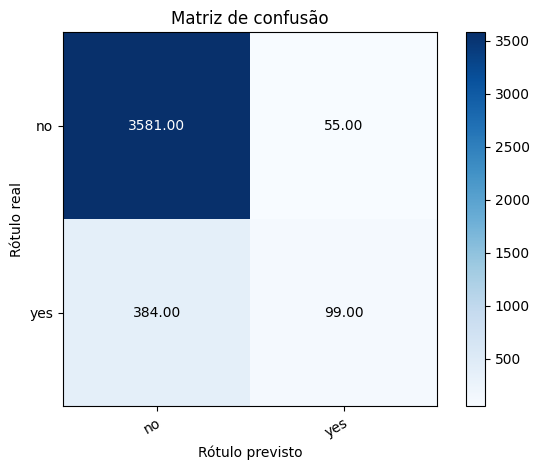

In [123]:
class_names = ["no", "yes"]
confusion_matrix = metrics.confusion_matrix(test_y, np.round(predictions))
ax, fig = plot_confusion_matrix(confusion_matrix, class_names)

In [125]:
print(f"Registrar a matriz de confusão no modelo {registered_model_version.name} versão {registered_model_version.version}")
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_id=registered_model_version.run_id):
    mlflow.log_figure(fig, "matriz_de_confusao.png")


Registrar a matriz de confusão no modelo from-idea-to-prod-job-model-14-22-55-42 versão 1


2024/10/15 01:00:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run container-training-15-00-07-23 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/7/runs/d9d67d93ba6b44129e834809dc152030.
2024/10/15 01:00:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/7.


In [126]:
# obter a URL pré-assinada para abrir a interface do MLflow
presigned_url = sm.create_presigned_mlflow_tracking_server_url(
    TrackingServerName=mlflow_name,
    ExpiresInSeconds=60,
    SessionExpirationDurationInSeconds=1800
)['AuthorizedUrl']

mlflow_run_link = f"{presigned_url.split('/auth')[0]}/#/experiments/1/runs/{registered_model_version.run_id}/artifacts"

In [127]:
# primeiro, abra a interface do MLflow - você pode fechar uma nova janela aberta
display(Javascript('window.open("{}");'.format(presigned_url)))

<IPython.core.display.Javascript object>

In [128]:
# segundo, abra a página de execução na interface do MLflow
display(Javascript('window.open("{}");'.format(mlflow_run_link)))

<IPython.core.display.Javascript object>

#### Opcional: implantar um endpoint a partir do estimador


Você também pode implantar o modelo a partir do estimador treinado usando o método [`deploy()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy) do estimador. Esta seção mostra como fazer isso.is.

In [129]:
# criar um endpoint em tempo real a partir do estimador treinado
endpoint_name_from_estimator = f"from-idea-to-prod-endpoint-estimator-{strftime('%d-%H-%M-%S', gmtime())}"

predictor_from_estimator = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    wait=True,  # Lembre-se, predictor.predict() não funcionará até que a implantação termine!
    # Ative a captura de dados, caso você queira experimentar o monitoramento:
    data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
        enable_capture=True,
        sampling_percentage=100,
        destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
    ),
    endpoint_name=endpoint_name_from_estimator,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-training-2024-10-15-01-02-08-493
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-estimator-15-01-02-07
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-estimator-15-01-02-07


-------!

In [131]:
# Carregar os dados de teste como arquivos CSV
test_x = pd.read_csv("tmp/test_x.csv", header=None)
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

In [132]:
# Fazer previsões usando o preditor do endpoint em tempo real
predictions = np.array(predictor_from_estimator.predict(test_x.values), dtype=float).squeeze()
predictions

array([0.05938949, 0.07139037, 0.18536061, ..., 0.04092945, 0.0345034 ,
       0.03125406])

In [133]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_x.index),
        test_x,
    ],
    axis=1,
)
test_results.head()

,y_pred,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,0.059389,0.000000,1.0,0.000000,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.071390,0.036364,1.0,0.000000,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.185361,0.000000,1.0,0.000000,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.240570,0.000000,1.0,0.142857,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.040983,0.000000,1.0,0.000000,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [134]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3583,53
1,383,100


In [135]:
test_auc = roc_auc_score(test_y, test_results["y_pred"])
print(f"Test-auc: {test_auc:.4f}")

Test-auc: 0.7702


In [136]:
# deletar o endpoint para evitar custos
predictor_from_estimator.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-estimator-15-01-02-07
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-estimator-15-01-02-07


## Transformação em lote (batch)
Se você deseja executar previsões offline em um grande conjunto de dados ou não precisa de um endpoint em tempo real, você pode usar a [transformação em lote](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) do SageMaker. Esta seção demonstra como usar a [transformação em lote do SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html).

In [137]:
transform_s3_url = f"s3://{bucket_name}/{bucket_prefix}/transform"
model_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

<div class="alert alert-info"> 💡 Para criar um transformador, use <b>opção 1</b> ou <b>opção 2</b>
</div>

### Opção 1: criar um transformador em lote a partir do estimador treinado
Você pode usar [`EstimatorBase.transformer()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer) para criar um transformador para um estimador:

In [138]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    role=sm_role,
    output_path=transform_s3_url,
    model_name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-15-01-08-12


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">Pule a Opção 2 e vá para a seção <b>Executar job de transformação</b>.
    </p>
</div>

### Opção 2: carregar um modelo de um jobs de treinamento
Alternativamente, você pode carregar um modelo a partir de um artefato de modelo produzido por um job de treinamento. Você cria um transformador com esse modelo.

In [90]:
model = session.create_model_from_job(
    training_job_name=training_job_name, 
    name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-23-15-00-28


In [91]:
transformer = sagemaker.transformer.Transformer(
    model_name=model,
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    assemble_with="Line",
    output_path=transform_s3_url,
    base_transform_job_name="from-idea-to-prod-trasform",
    sagemaker_session=session,
)

### Executar o job de transformação


<svg width="800" height="125" viewBox="0 0 800 125" xmlns="http://www.w3.org/2000/svg">
    <defs>
        <linearGradient id="fadeGradient" x1="0" x2="1">
            <stop offset="0%" stop-color="#F0F0F0"/>
            <stop offset="100%" stop-color="#F0F0F0" stop-opacity="0"/>
        </linearGradient>
        <mask id="fadeMask">
            <rect x="0" y="0" width="750" height="125" fill="white"/>
            <rect x="750" y="0" width="50" height="125" fill="url(#fadeGradient)"/>
        </mask>
    </defs>
    <path d="M3,50 A50,50 0 0 1 53,3 L797,3 L797,97 L97,97 L50,115 L3,97 Z" fill="#F0F0F0" stroke="#E0E0E0" stroke-width="1" mask="url(#fadeMask)"/>
    <circle cx="50" cy="50" r="30" fill="#57c4f8" stroke="#57c4f8" stroke-width="1"/>
    <circle cx="50" cy="50" r="25" fill="#F0F0F0"/>
    <line x1="50" y1="50" x2="50" y2="30" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <line x1="50" y1="50" x2="65" y2="50" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <text x="100" y="34" font-family="Arial, sans-serif" font-size="14" fill="#333333">A próxima célula pode levar alguns minutos para ser executada. Por favor, seja paciente.</text>
</svg>

In [ ]:
transform_job_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

transformer.transform(    
    data=f"{test_s3_url}/test_x.csv",
    content_type="text/csv",
    split_type="Line", 
    job_name=transform_job_name,
    wait=True,
)

INFO:sagemaker:Creating transform job with name: from-idea-to-prod-transform-15-01-08-32


..............................

In [140]:
while sm.describe_transform_job(
        TransformJobName=transformer._current_job_name
    )["TransformJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {transformer._current_job_name} completed")

In [141]:
transformer.output_path

's3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/transform'

### Avalie as predições

In [142]:
!aws s3 ls {transformer.output_path}/

2024-10-15 01:14:13      82323 test_x.csv.out


In [143]:
!aws s3 cp {transformer.output_path}/test_x.csv.out tmp/predictions.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/transform/test_x.csv.out to tmp/predictions.csv
download: s3://sagemaker-us-east-1-533267005474/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [144]:
predictions = pd.read_csv("tmp/predictions.csv", names=["y_prob"])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

#### Crosstab

In [145]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.array(np.round(predictions), dtype=float).squeeze(), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3583,53
1,383,100


In [146]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.4f}")

Test-auc: 0.7702


#### ROC curve

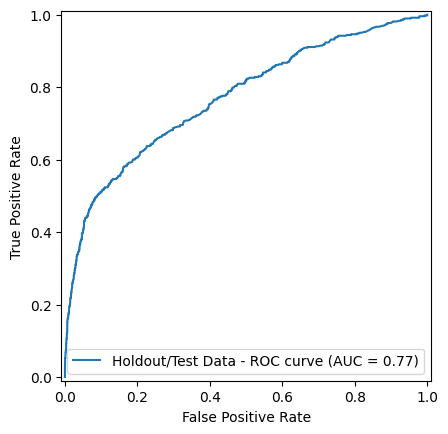

In [147]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Holdout/Test Data - ROC curve')
roc_display.plot()
plt.show()

#### Confusion matrix

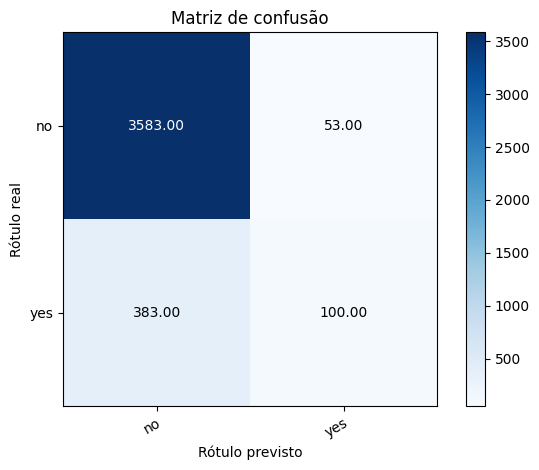

In [148]:
class_names = ["no", "yes"]
confusion_matrix = metrics.confusion_matrix(test_y, np.round(predictions))
ax, fig = plot_confusion_matrix(confusion_matrix, class_names)

#### Precision-recall curve

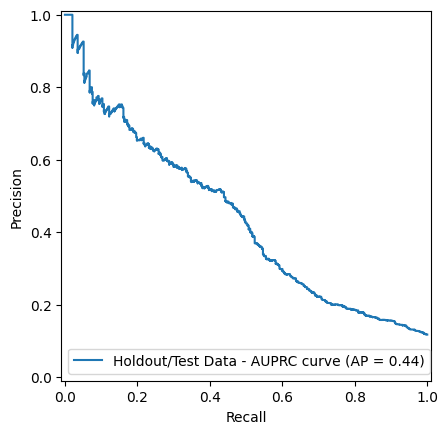

In [149]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_y, predictions)
average_precision= metrics.average_precision_score(test_y, predictions)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Holdout/Test Data - AUPRC curve')
pr_display.plot()
plt.show()

## Explore experimentos e registro de modelos com a interface do MLflow
Você pode ver todas as métricas, parâmetros e artefatos registrados na interface do MLflow. Para iniciar a interface do MLflow, escolha **MLflow** no painel **Aplicação** da interface do Studio, selecione seu servidor MLflow e escolha **Abrir MLflow**:

![](img/mlflow-open.png)

Na interface do MLflow, você pode navegar por experimentos, execuções e modelos registrados:

![](img/experiment-mlflow-2.png)

![](img/models-mlflow-2.png)

![](img/model-fig-mlflow.png)

---

## Opcional: Otimização de hiperparâmetros (HPO)
Você pode seguir para a seção <b>Clean-up</b>.</div>

A [otimização automática de modelos do Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), também chamada de otimização de hiperparâmetros (HPO), encontra o modelo com melhor desempenho em relação a uma métrica objetiva definida, executando vários jobs de treinamento no conjunto de dados usando o algoritmo e os intervalos de hiperparâmetros que você especifica. O HPO do SageMaker suporta busca aleatória, otimização bayesiana e [hyperband](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) como estratégias de ajuste.

In [ ]:
suffix = strftime('%d-%H-%M-%S', gmtime())
hpo_experiment_name = f"from-idea-to-prod-hpo-{suffix}"
registered_hpo_model_name = f"from-idea-to-prod-hpo-model-{suffix}"

mlflow.set_experiment(hpo_experiment_name)

In [113]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [114]:
# configurar intervalos de hiperparâmetros
hp_ranges = {
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
    "colsample_bytree": ContinuousParameter(0, 1),
}

# configurar a métrica objetiva
objective = "validation:auc"

# configurar o estimador no modo script
hpo_estimator = XGBoost(
    entry_point='train.py',
    source_dir='./training',
    framework_version="1.7-1",  
    hyperparameters=hyperparams,
    role=sm_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    output_path=output_s3_url,
    base_job_name="from-idea-to-prod-training",
    environment={
        'MLFLOW_TRACKING_ARN': mlflow_arn,
        'MLFLOW_EXPERIMENT_NAME': hpo_experiment_name,
        'USER': user_profile_name,
        'REGION': region,
    }
)

# instanciar um objeto HPO
tuner = HyperparameterTuner(
    estimator=hpo_estimator,  # o objeto estimador do SageMaker
    hyperparameter_ranges=hp_ranges,  # o intervalo de hiperparâmetros
    max_jobs=10,  # número total de jobs HPO
    max_parallel_jobs=3,  # quantos jobs HPO podem ser executados em paralelo
    strategy="Bayesian",  # a estratégia de otimização interna do HPO
    objective_metric_name=objective,  # a métrica objetiva a ser usada para HPO
    objective_type="Maximize",  # maximizar ou minimizar a métrica objetiva
    base_tuning_job_name="from-idea-to-prod-hpo",
    early_stopping_type="Auto",
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.xlarge.


### Execute o HPO
Agora execute o job de HPO. Leva cerca de 10 minutos para ser concluído.

<svg width="800" height="125" viewBox="0 0 800 125" xmlns="http://www.w3.org/2000/svg">
    <defs>
        <linearGradient id="fadeGradient" x1="0" x2="1">
            <stop offset="0%" stop-color="#F0F0F0"/>
            <stop offset="100%" stop-color="#F0F0F0" stop-opacity="0"/>
        </linearGradient>
        <mask id="fadeMask">
            <rect x="0" y="0" width="750" height="125" fill="white"/>
            <rect x="750" y="0" width="50" height="125" fill="url(#fadeGradient)"/>
        </mask>
    </defs>
    <path d="M3,50 A50,50 0 0 1 53,3 L797,3 L797,97 L97,97 L50,115 L3,97 Z" fill="#F0F0F0" stroke="#E0E0E0" stroke-width="1" mask="url(#fadeMask)"/>
    <circle cx="50" cy="50" r="30" fill="#57c4f8" stroke="#57c4f8" stroke-width="1"/>
    <circle cx="50" cy="50" r="25" fill="#F0F0F0"/>
    <line x1="50" y1="50" x2="50" y2="30" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <line x1="50" y1="50" x2="65" y2="50" stroke="#57c4f8" stroke-width="3" stroke-linecap="round"/>
    <text x="100" y="34" font-family="Arial, sans-serif" font-size="14" fill="#333333">A próxima célula pode levar alguns minutos para ser executada. Por favor, seja paciente.</text>
    <text x="100" y="56" font-family="Arial, sans-serif" font-size="14" fill="#333333">Você pode ignorar com segurança as mensagens de aviso.</text>
</svg>

In [ ]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
)

In [ ]:
tuner.describe()['HyperParameterTuningJobStatus']

Para ver os detalhes do job de HPO no console do SageMaker, clique no link construído pela célula abaixo:


In [117]:
# Monstre o HPO Job
display(
    HTML('<b>See the SageMaker <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/{}">HPO job</a></b>'.format(
            region, region, tuner.latest_tuning_job.job_name))
)

### Veja os resultados do HPO
Agora obtenha os resultados e veja o melhor job de treinamento.

In [118]:
best_training_job = tuner.describe()['BestTrainingJob']

In [ ]:
best_training_job

### Registre o melhor modelo HPO no registro de modelos
Registre o melhor modelo HPO com os hiperparâmetros, métricas e artefatos do modelo no registro de modelos do MLflow.

In [142]:
# encontre a execução com o melhor modelo HPO
best_hpo_model_run_id = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name(hpo_experiment_name).experiment_id], 
    filter_string=f"tags.mlflow.source.name LIKE '%{best_training_job['TrainingJobArn'].split('/')[-1]}%'",
)['run_id'][0]

In [143]:
best_hpo_model_run_id

'dca26c9b57644181a7c29f448dcdf2f8'

In [ ]:
# Registre o modelo
model_uri = f"runs:/{best_hpo_model_run_id}/model"
registered_hpo_model_version = mlflow.register_model(model_uri, registered_hpo_model_name)

Como próximo passo, você precisa implantar o melhor modelo HPO e testá-lo. Você pode escolher uma das seguintes opções abaixo.

### Execute inferência local com o melhor modelo HPO


In [ ]:
# obter o modelo do MLflow Model Registry
model_uri = registered_hpo_model_version.source
model = mlflow.xgboost.load_model(model_uri)

# carregar dados
test_x = loadtxt("tmp/test_x.csv", delimiter=",")
test_y = loadtxt("tmp/test_y.csv", delimiter=",")

# prever
dtest = xgb.DMatrix(test_x)

predictions = np.array(model.predict(dtest), dtype=float).squeeze()
predictions

In [ ]:
pd.crosstab(
    index=test_y,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

In [ ]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.4f}")

Há apenas pequenas melhorias nas métricas do modelo. Isso pode indicar que o modelo XGBoost já está no seu limite. Você pode querer explorar outros tipos de modelos para melhorar a precisão da previsão para este caso de uso.

---

## Clean-up
Para evitar cobranças, remova o endpoint hospedado que você criou.

In [121]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-15-00-30-33
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-15-00-30-33


## Continue com o passo 3
abra o [notebook](03-sagemaker-pipeline.ipynb) do passo 3.

## Ideias de desenvolvimento adicional para seus projetos do mundo real
- [Gerenciar experimentos](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow.html)
- Usar o [Amazon SageMaker Data Wrangler](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler.html) para criar um fluxo visual de processamento de dados e engenharia de features sem código ou com baixo código.
- Experimentar o [SageMaker Canvas](https://docs.aws.amazon.com/sagemaker/latest/dg/canvas.html) sem código em seus dados para realizar análises e usar ML automatizado para construir modelos e gerar previsões

## Recursos adicionais
- [Usando contêineres Docker com SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)
- [Como criar e usar um contêiner SageMaker personalizado: workshop prático do SageMaker](https://sagemaker-workshop.com/custom/containers.html)
- [Amazon SageMaker Immersion Day](https://catalog.us-east-1.prod.workshops.aws/workshops/63069e26-921c-4ce1-9cc7-dd882ff62575/en-US)
- [Direcionando Marketing Direto com Amazon SageMaker XGBoost](https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/processing_xgboost.ipynb)
- [Treine um Modelo de Aprendizado de Máquina](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-train-a-model/)
- [Implante um Modelo de Aprendizado de Máquina em um Endpoint de Inferência em Tempo Real](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-deploy-model-to-real-time-inference-endpoint/)
- [Workshop Amazon SageMaker 101](https://catalog.us-east-1.prod.workshops.aws/workshops/0c6b8a23-b837-4e0f-b2e2-4a3ffd7d645b/en-US)
- [Repositório de código do Workshop Amazon SageMaker 101](https://github.com/aws-samples/sagemaker-101-workshop)
- [Amazon SageMaker com XGBoost e Ajuste de Hiperparâmetros para previsões de Marketing Direto](https://github.com/aws-samples/sagemaker-101-workshop/blob/main/builtin_algorithm_hpo_tabular/SageMaker%20XGBoost%20HPO.ipynb)

# Encerrar kernel


In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>